In [1]:
from torchvision.datasets import MNIST, CIFAR10
from mynn.data import mnist_augment, preprocess, basic_mnist_augment, merge_datasets, cifar10_augment, basic_cifar10_augment
from mynn.layer import Flatten, Linear, ReLU, He, Conv, Dropout, Pooling, BN
from mynn.layer.blocks import BasicBlock
from mynn.loss import CrossEntropy
from mynn import Model
from mynn.optimizer import SGD, Adam, MomentGD
from mynn.runner import RunnerM, EarlyStopping, CosineAnnealingLR
import cupy as cp

In [2]:
test_dataset = CIFAR10(
    root="./dataset",
    train=False,
    transform=basic_cifar10_augment(train=False),
    download=False
)
test_images, test_labels = preprocess(test_dataset)
test_images = cp.asarray(test_images)
test_labels = cp.asarray(test_labels)

test_set = (test_images, test_labels)
import numpy as np

print("Min pixel value:", cp.min(test_images))
print("Max pixel value:", cp.max(test_images))

Min pixel value: 0.0
Max pixel value: 1.0


In [3]:
# 4. 测试集评估
model = Model().load_model("best_model-vgg.pickle")
loss_fn = CrossEntropy(model=model)
runner = RunnerM(model=model, loss=loss_fn, optimizer=None)
# 5. 评估并输出
test_loss, test_acc = runner.evaluate(test_set, batch_size=128)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Model loaded from: best_model-vgg.pickle
Test loss: 0.9749, Test accuracy: 0.7832


In [4]:
from mynn.attack import bim_attack
adv_test_images = bim_attack(
    model=model, 
    images=test_images, 
    labels=test_labels, 
    loss_fn=loss_fn,
    epsilon=2/255,
    num_steps=5,
    step_size=0.5/255
)

test_set_adv = (adv_test_images, test_labels)

In [5]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 8.49979, Test accuracy: 0.35591


In [17]:
import matplotlib.pyplot as plt
def plot_images(images, labels, title=""):
    """
    显示前五张图片，自动处理 Cupy/NumPy、范围归一化等
    - images: (N, C, H, W)，可为 Cupy 或 NumPy
    - labels: (N,) 或 (N, C)
    """
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title)

    for i in range(5):
        ax = axes[i]

        # 取单张图片，并转 (H, W, C)
        img = images[i].transpose(1, 2, 0)

        # 如果是 cupy，则转为 numpy
        if hasattr(img, 'get'):
            img = img.get()

        # 如果像素最大值超过1，说明是 [0, 255]，就归一化
        if img.max() > 1:
            img = img / 255.0

        img = np.clip(img, 0, 1)  # 保险剪裁，防止 overflow

        ax.imshow(img)
        # 标签显示
        label = labels[i]
        label_text = np.argmax(label) if len(label.shape) > 0 and label.shape[0] > 1 else label
        ax.set_title(f"Label: {label_text}")
        ax.axis('off')

    plt.show()

Displaying original images...


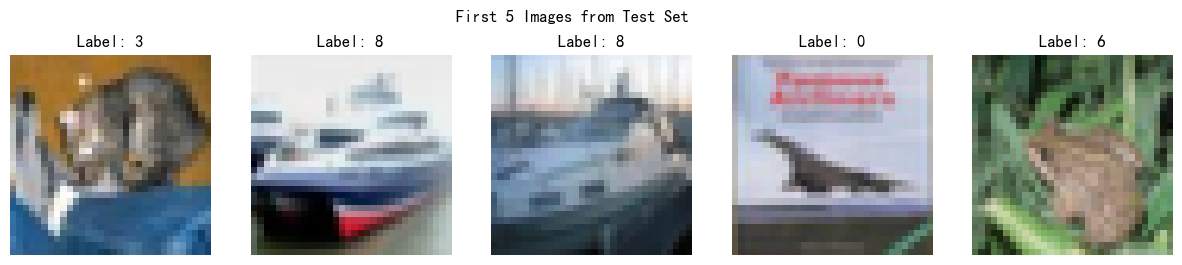

Displaying adversarial images...


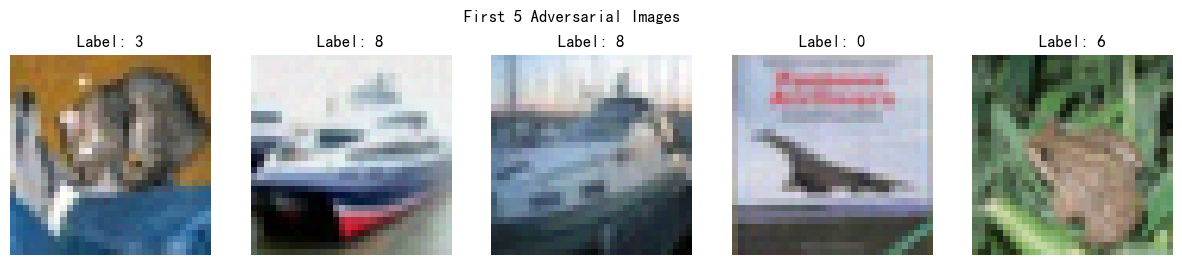

In [18]:
print("Displaying original images...")
plot_images(test_images, test_labels, title="First 5 Images from Test Set")

print("Displaying adversarial images...")
plot_images(adv_test_images, test_labels, title="First 5 Adversarial Images")

In [4]:
weight_decay_val = 0.001

layers2 = [
    Conv(in_channel=3, out_channel=64, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 64, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=64, out_channel=128, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 128, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=128, out_channel=256, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 256, 1, 1)),
    ReLU(),

    Conv(in_channel=256, out_channel=256, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 256, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=256, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Conv(in_channel=512, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=512, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Conv(in_channel=512, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Pooling(kernel=2),

    Flatten(),
    Linear(in_channel=512 * 1 * 1, out_channel=512, weight_decay=0.001),
    ReLU(),
    Linear(in_channel=512, out_channel=512, weight_decay=0.001),
    ReLU(),
    Linear(in_channel=512, out_channel=10, weight_decay=0.001)
]


In [5]:
model2 = Model(layers2)
optimizer2 = Adam(model=model2, lr=0.001)
loss_fn2  = CrossEntropy(model=model2)
runner2  = RunnerM(model=model2, loss=loss_fn2, optimizer=optimizer2)

[Adversarial Train] Epoch 1/8: 100%|██████████| 352/352 [19:25<00:00,  3.31s/batch, accuracy=0.444, loss=1.43]
train_loss: 1.24132, train_acc: 0.54805
dev_loss  : 1.25702, dev_acc  : 0.54635
### Best model saved to: best_models\2025-05-24_00-03-30\best_model.pickle
### Best validation accuracy updated: 0.00000 -> 0.54635
Patience Counter Reset to 0

[Adversarial Train] Epoch 2/8: 100%|██████████| 352/352 [19:26<00:00,  3.31s/batch, accuracy=0.458, loss=1.43]
train_loss: 0.97765, train_acc: 0.66394
dev_loss  : 1.03020, dev_acc  : 0.64009
### Best model saved to: best_models\2025-05-24_00-03-30\best_model.pickle
### Best validation accuracy updated: 0.54635 -> 0.64009
Patience Counter Reset to 0

[Adversarial Train] Epoch 3/8: 100%|██████████| 352/352 [19:28<00:00,  3.32s/batch, accuracy=0.625, loss=0.963]
train_loss: 0.76510, train_acc: 0.74646
dev_loss  : 0.87926, dev_acc  : 0.69804
### Best model saved to: best_models\2025-05-24_00-03-30\best_model.pickle
### Best validation accuracy 

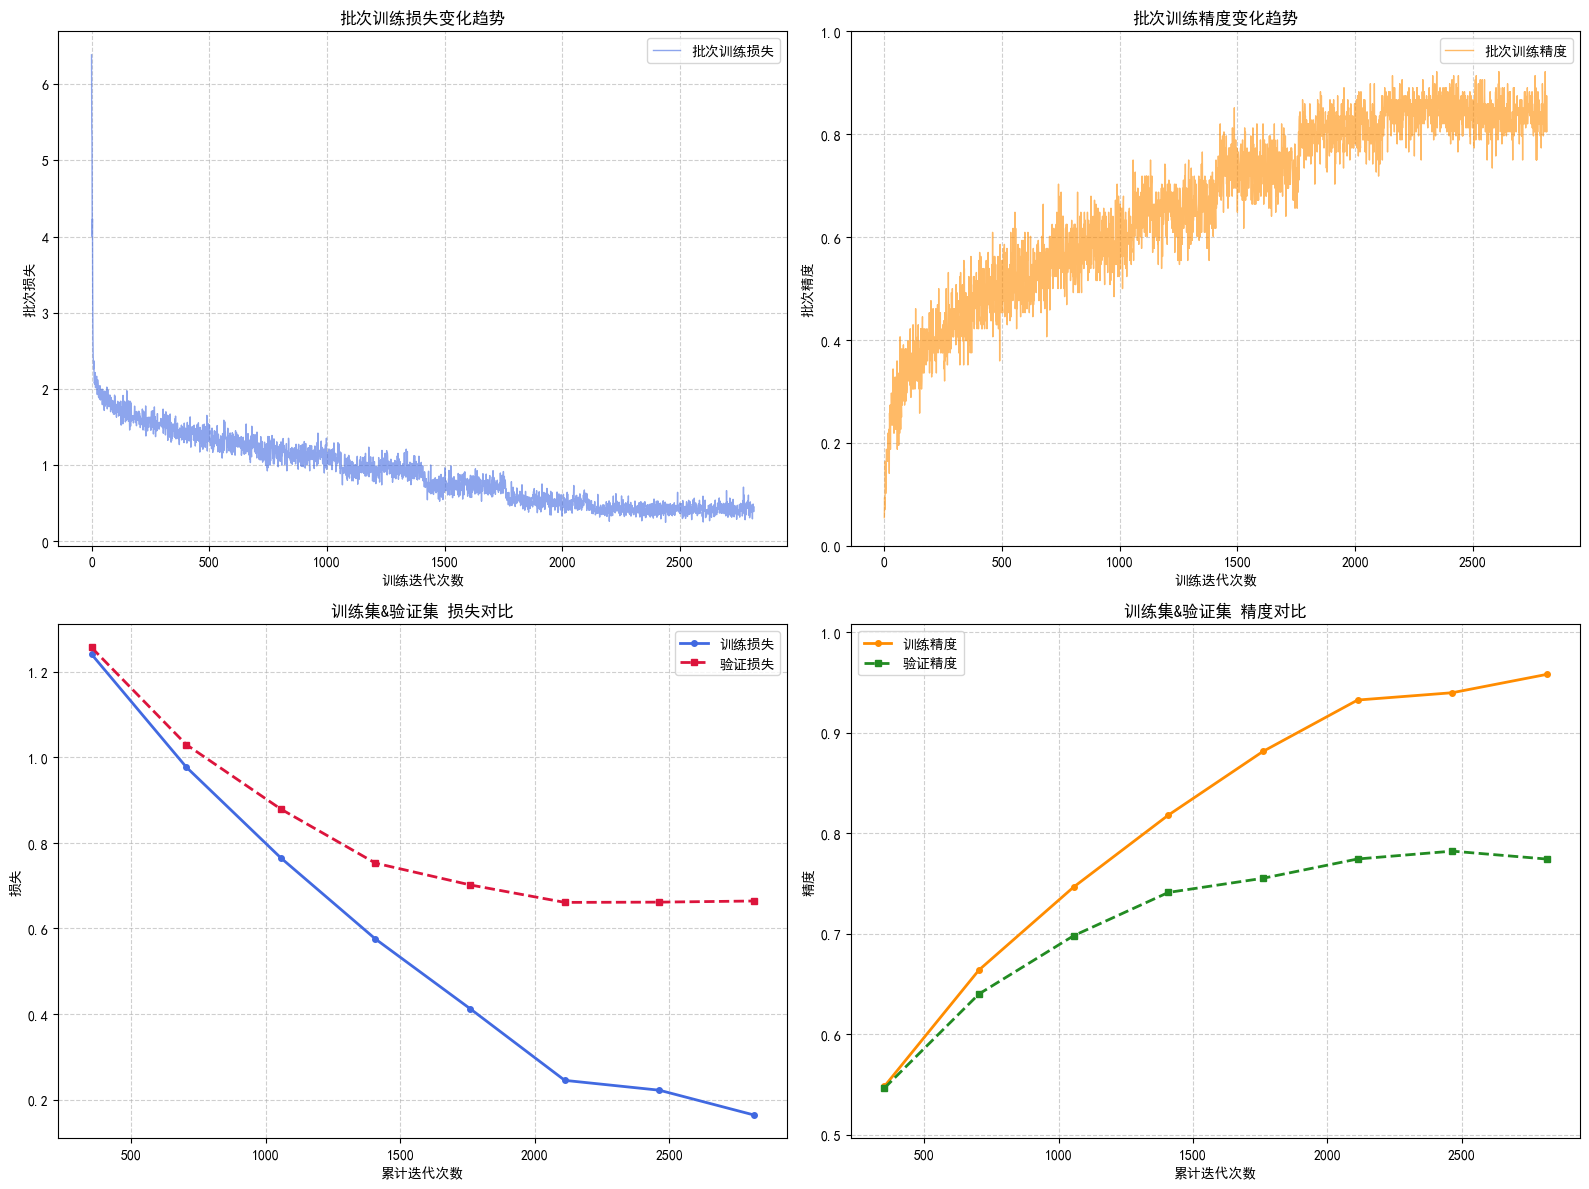

In [6]:
runner2.train_with_attack(
        train_set=train_set,
        dev_set=dev_set,
        batch_size=128,
        num_epochs=8,
        scheduler=CosineAnnealingLR(
            optimizer=optimizer2,
            T_max=5,
            eta_min=1e-5,
        ),
        strategy=EarlyStopping(
            patience=5,
            delta=0.0,
        ),
        shuffle=True,
        save_dir='best_models',
        attack_strategy='bim',
        epsilon=2/255,
        num_steps=5,
        step_size=0.5/255
    )

In [8]:
test_loss, test_acc = runner2.evaluate(test_set, batch_size=64)
print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

Test loss: 0.71821, Test accuracy: 0.76075


In [11]:
from mynn.attack import bim_attack
adv_test_images = bim_attack(
    model=model2,
    images=test_images,
    labels=test_labels,
    loss_fn=loss_fn2,
    epsilon=2/255,
    num_steps=5,
    step_size=0.5/255,
)

test_set_adv = (adv_test_images, test_labels)
adv_loss, adv_acc = runner2.evaluate(test_set_adv, batch_size=128)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 1.50797, Test accuracy: 0.54648
